# Code Flow
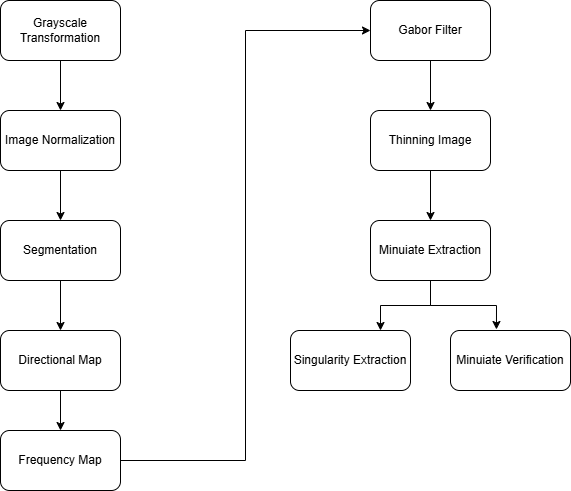

# Preprocessing

In [1]:
import cv2 as cv
from glob import glob
import os
import numpy as np
from utils.poincare import calculate_singularities
from utils.segmentation import create_segmented_and_variance_images
from utils.normalization import normalize
from utils.gabor_filter import gabor_filter
from utils.frequency import ridge_freq
from utils import orientation
from utils.crossing_number import calculate_minutiaes
from tqdm import tqdm
from utils.skeletonize import skeletonize
import matplotlib.pyplot as plt


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "c:\Users\PC\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\PC\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "c:\Users\PC\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\PC\AppData\Local\Programs\Python\Python39\lib\site-packages\traitlets\config\appl

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "c:\Users\PC\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\PC\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "c:\Users\PC\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\PC\AppData\Local\Programs\Python\Python39\lib\site-packages\traitlets\config\appl

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



ImportError: numpy.core.multiarray failed to import

In [4]:
# Define constants
DATASET_PATH = '../dataset/'
OUT_IMG_PATH = '../processed_img/'
BLOCK_SIZE = 16

def show_img(original_img, processed_img, title="Image"):
    processed_img = cv.cvtColor(processed_img.copy(), cv.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(processed_img)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [48]:
img_name = input("Enter the image name: ")
test_img = cv.imread('../dataset/DB2_B/' + img_name, 0)

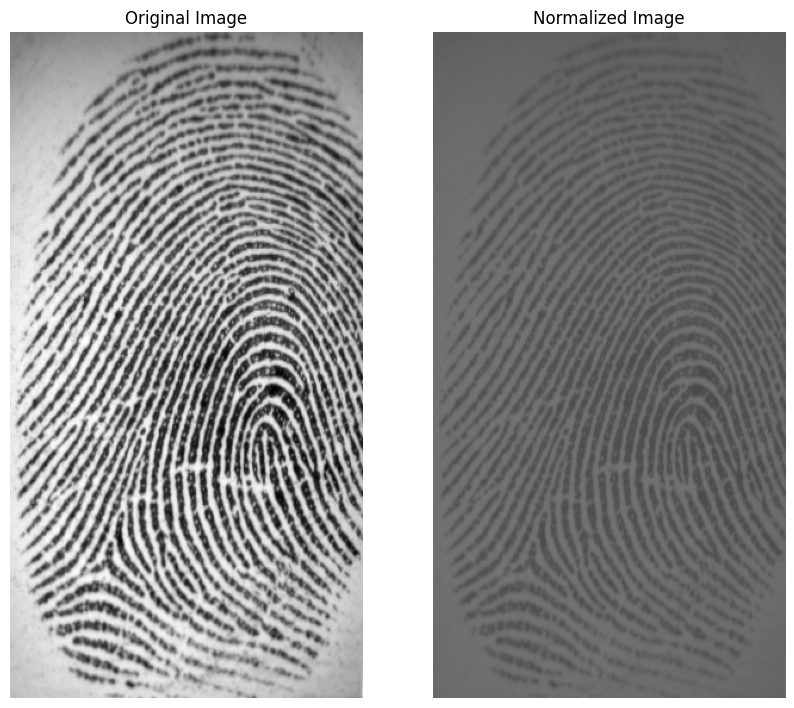

In [49]:

# Normalization - removes the effects of sensor noise and finger pressure differences.
normalized_img = normalize(test_img.copy(), float(100), float(100))
show_img(test_img, normalized_img, "Normalized Image")

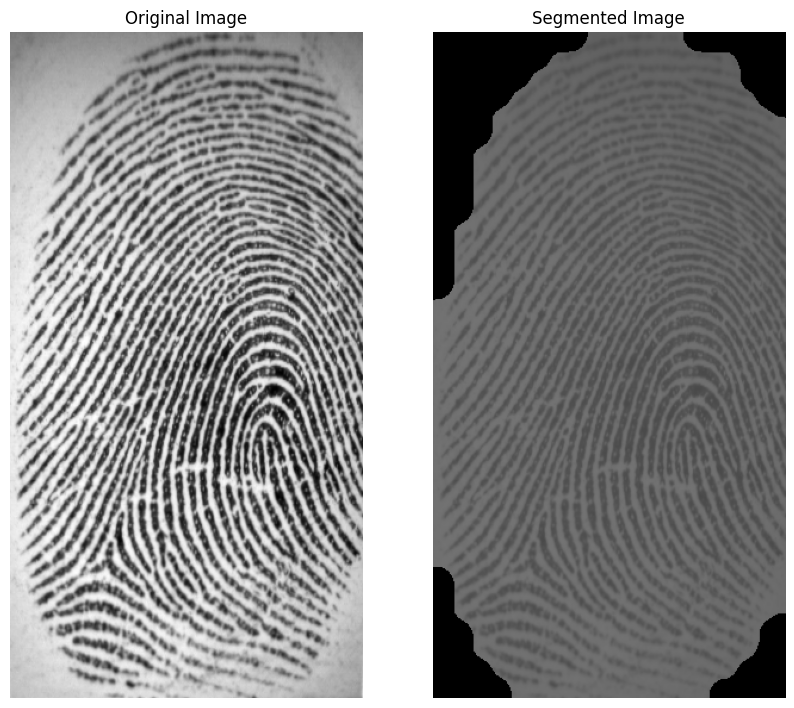

In [50]:
# ROI and normalisation
(segmented_img, normim, mask) = create_segmented_and_variance_images(normalized_img, BLOCK_SIZE, 0.2)

show_img(test_img, segmented_img, "Segmented Image")

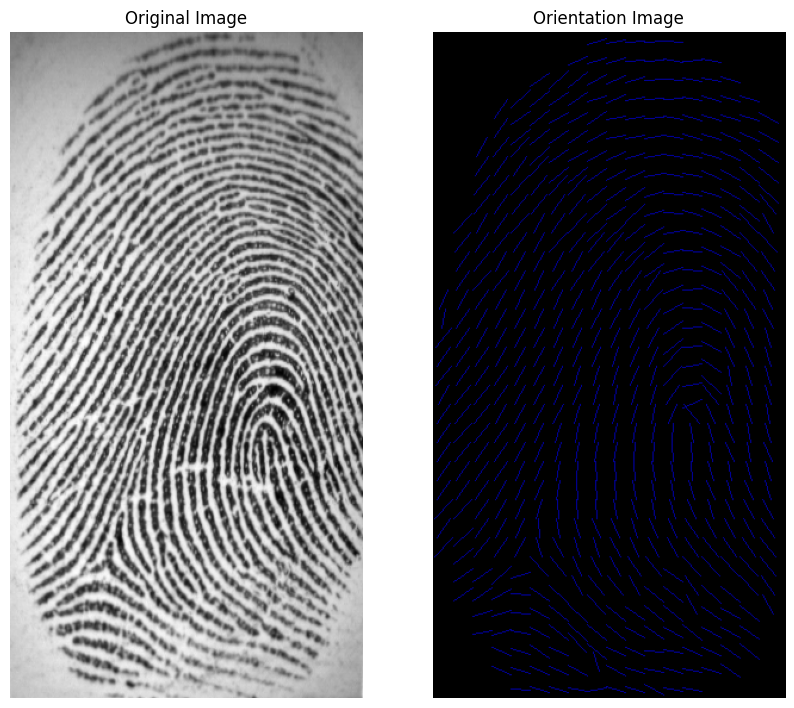

In [51]:
# Orientations
angles = orientation.calculate_angles(normalized_img, W=BLOCK_SIZE, smoth=False)
orientation_img = orientation.visualize_angles(segmented_img, mask, angles, W=BLOCK_SIZE)

show_img(test_img, orientation_img, "Orientation Image")

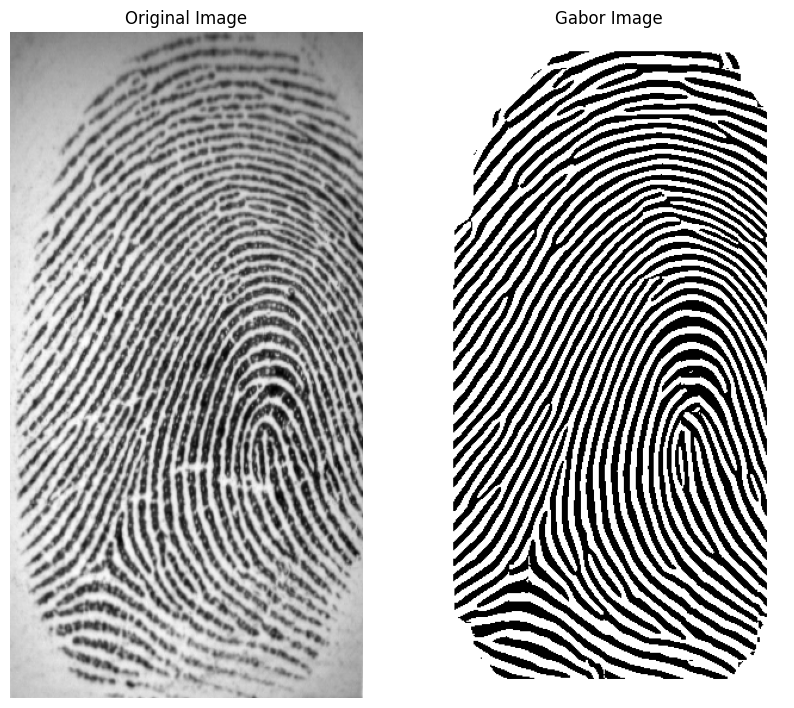

In [52]:
# Find the overall frequency of ridges in Wavelet Domain
freq = ridge_freq(normim, mask, angles, BLOCK_SIZE, kernel_size=5, minWaveLength=5, maxWaveLength=15)

# Create gabor filter and do the actual filtering
gabor_img = gabor_filter(normim, angles, freq)

show_img(test_img, gabor_img, "Gabor Image")

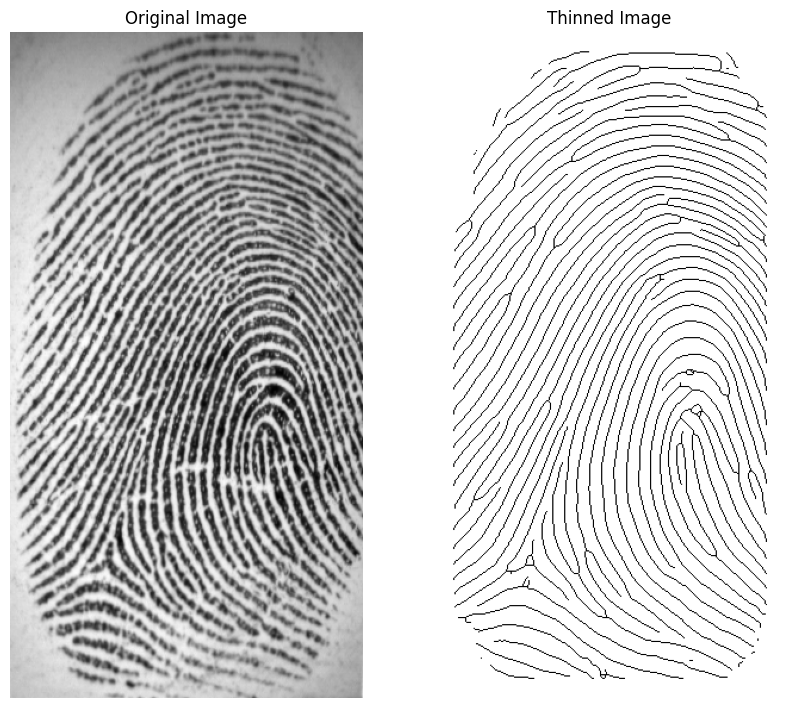

In [53]:
# Thinning oor skeletonize
thin_image = skeletonize(gabor_img)

show_img(test_img, thin_image, "Thinned Image")

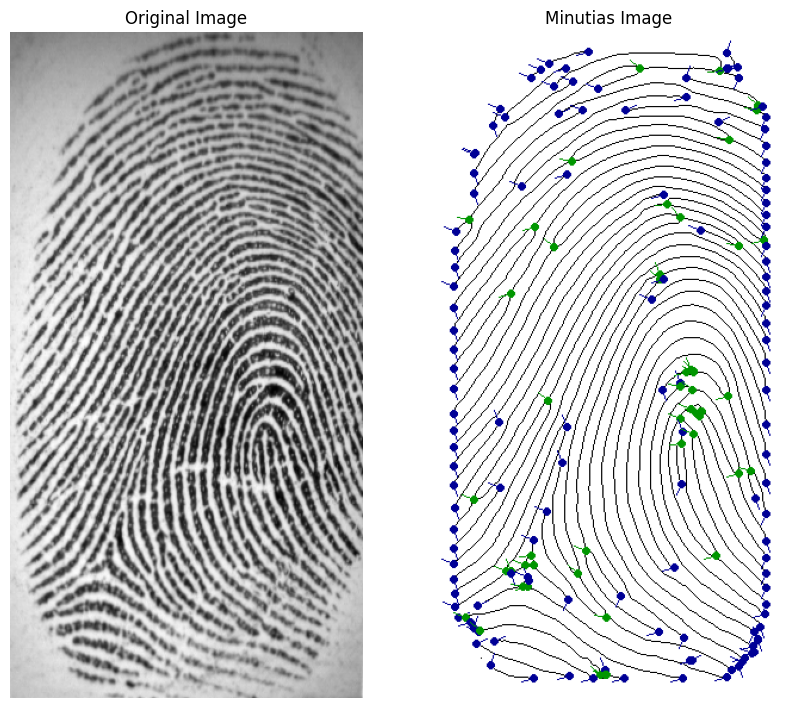

In [54]:
# Minutias
minutias = calculate_minutiaes(thin_image, kernel_size=3)

show_img(test_img, minutias, "Minutias Image")

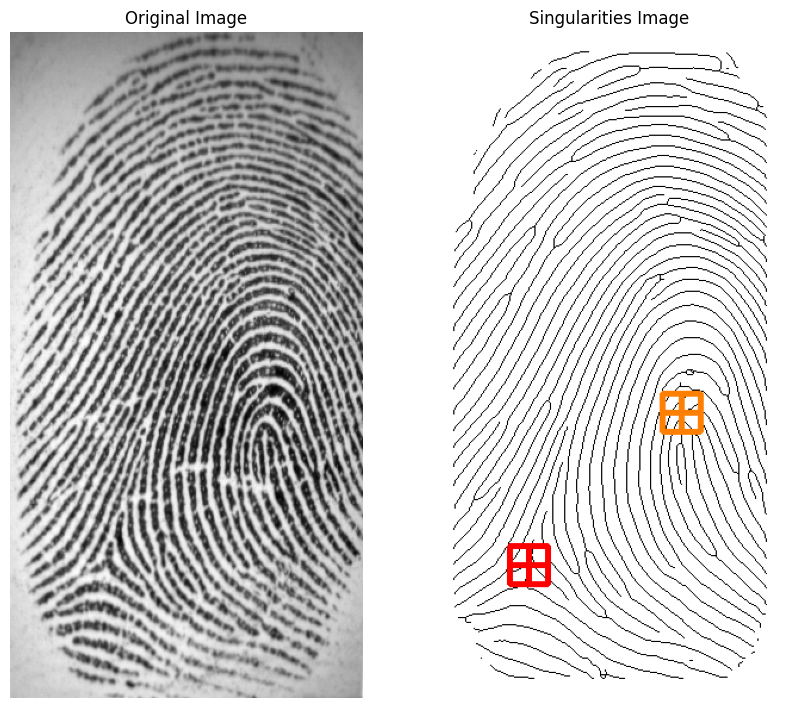

In [55]:
# Singularities
singularities_img = calculate_singularities(thin_image, angles, 1, BLOCK_SIZE, mask)

show_img(test_img, singularities_img, "Singularities Image")

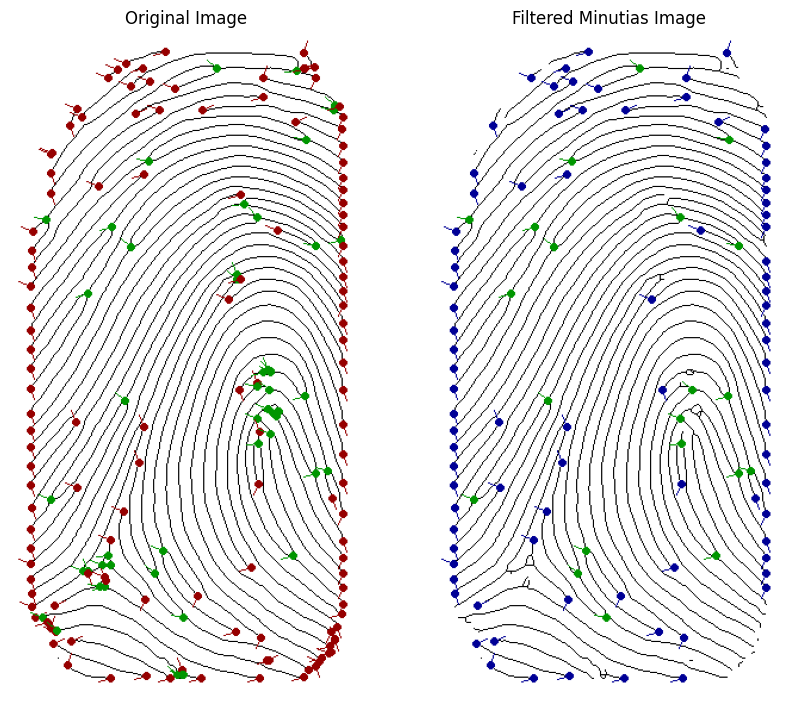

In [56]:
filtered_img = calculate_minutiaes(thin_image, kernel_size=3, filter=True)

show_img(minutias, filtered_img, "Filtered Minutias Image")

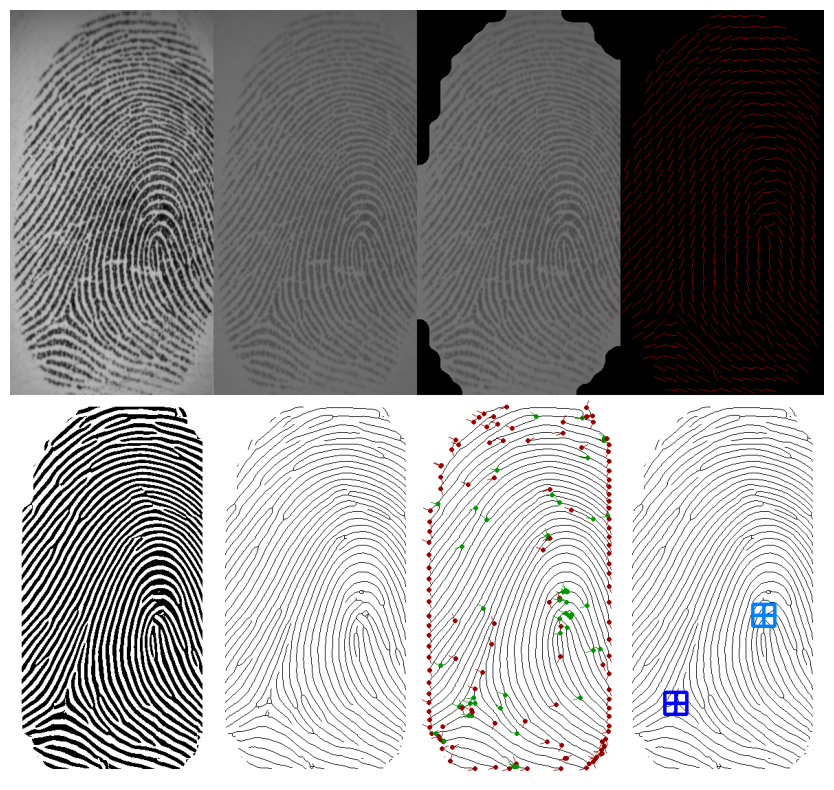

In [57]:
output_imgs = [test_img, normalized_img, segmented_img, orientation_img, gabor_img, thin_image, minutias, singularities_img]
for i in range(len(output_imgs)):
    if len(output_imgs[i].shape) == 2:
        output_imgs[i] = cv.cvtColor(output_imgs[i], cv.COLOR_GRAY2RGB)
results = np.concatenate([np.concatenate(output_imgs[:4], 1), np.concatenate(output_imgs[4:], 1)]).astype(np.uint8)

plt.figure(figsize=(20, 10))
plt.imshow(results)
plt.axis('off')
plt.show()

# Matching Method

## KNN Model

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

In [6]:
labels = [str(i) for i in range(101, 111)]

In [1]:
X = []
for img_name in tqdm(labels):
    temp = get_features_vector(img_name, 'DB2_B')

len(X)
        

NameError: name 'tqdm' is not defined